In [1]:
# Load Python libraries
from sklearn import cross_validation, grid_search, metrics, ensemble
#cross_validation交叉验证, grid_search参数搜索, metrics 模块实现了针对特定目的评估预测误差的 ，ensemble集成方法相关
import xgboost as xgb
#可扩展，便携，分布式 gradient boosting (GBDT, GBRT or GBM) 算法的一个库,梯度提升决策树
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

C:\Users\tree\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\tree\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\tree\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported.

In [2]:
# Load data
df = pd.read_csv('input/train.csv')

# 1% sample of items
df = df.sample(frac=0.01)

In [3]:
# Load and join songs data
songs = pd.read_csv('input/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load and join songs data
members = pd.read_csv('input/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 73774 entries, 0 to 73773
Data columns (total 18 columns):
msno                      73774 non-null object
song_id                   73774 non-null object
source_system_tab         73529 non-null object
source_screen_name        69595 non-null object
source_type               73559 non-null object
target                    73774 non-null int64
song_length               73772 non-null float64
genre_ids                 72580 non-null object
artist_name               73772 non-null object
composer                  57181 non-null object
lyricist                  42182 non-null object
language                  73771 non-null float64
city                      73774 non-null int64
bd                        73774 non-null int64
gender                    44011 non-null object
registered_via            73774 non-null int64
registration_init_time    73774 non-null int64
expiration_date           73774 non-null int64
dtypes: float64(2), int64(6), o

In [5]:
df.isnull().sum()/df.isnull().count()*100


msno                       0.000000
song_id                    0.000000
source_system_tab          0.332095
source_screen_name         5.664597
source_type                0.291431
target                     0.000000
song_length                0.002711
genre_ids                  1.618456
artist_name                0.002711
composer                  22.491664
lyricist                  42.822675
language                   0.004066
city                       0.000000
bd                         0.000000
gender                    40.343481
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [6]:
# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

In [7]:

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [8]:
df.head()


,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,TL7CCbpvevnYaBqP7dYUSo+qdaYpUSe49cllCUHq1qM=,T8e6TMA26BIaKTjLCqq/8Bdi7F+LDUOEFOXGvOf/5vA=,search,Album more,album,0,238837.0,2022,ONE OK ROCK,unknown,...,male,3,2012-05-23,2017-10-31,2012,5,23,2017,10,31
1,z+Hwg8HsbuFiry5i3cyYLDo+H+h6FINM7U5TZ6YQV1M=,CTGLJvAVVqzedEdjAbnak4jROSkodsKtbrP3xpiZxUo=,radio,Radio,radio,0,157596.0,958,Best Piano Classics 100,Claude Debussy,...,female,9,2006-02-21,2017-10-14,2006,2,21,2017,10,14
2,bhN+Wl1CWJ9L/av6pySGTfJtrmfmfbcUB6DMgbBSAbI=,BU3Zz2nHFfKfes3ihHkZADX14RJzWpSMX2r3shflWkc=,discover,Online playlist more,online-playlist,1,254197.0,430,Greg Holden,unknown,...,male,9,2013-12-24,2018-02-14,2013,12,24,2018,2,14
3,EmW6uZVU8a0y5CoWSsc+V3+6E80hSVMo84VVxj49Kkk=,UPIWRmM9McD/HSS/ygwJEwN5nr10LgyIQ7RODjSLMec=,my library,Local playlist more,local-library,1,226951.0,465,蔡健雅 (Tanya Chua),蔡健雅,...,male,7,2016-06-27,2017-09-30,2016,6,27,2017,9,30
4,LkBDnzO64HlpsSLunPMlqsuf3y04C39CPS3J9KDjsUI=,zg6SzD3aqsnOqqyhFYTdbCNFrhSACbwefB/ZFi68AO0=,my library,Local playlist more,local-library,1,216816.0,465,G.E.M.鄧紫棋,G.E.M. 鄧紫棋,...,female,4,2016-12-03,2017-09-07,2016,12,3,2017,9,7


In [9]:
# Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [10]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

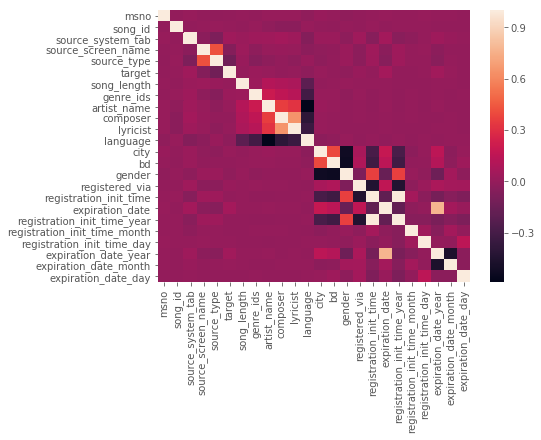

In [11]:
# Сorrelation matrix
plt.figure(figsize=[7,5])
sns.heatmap(df.corr())
plt.show()

In [12]:
# Drop columns
df = df.drop(['expiration_date', 'lyricist'], 1)

In [13]:
# Model with the best estimator
model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'target']], df.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

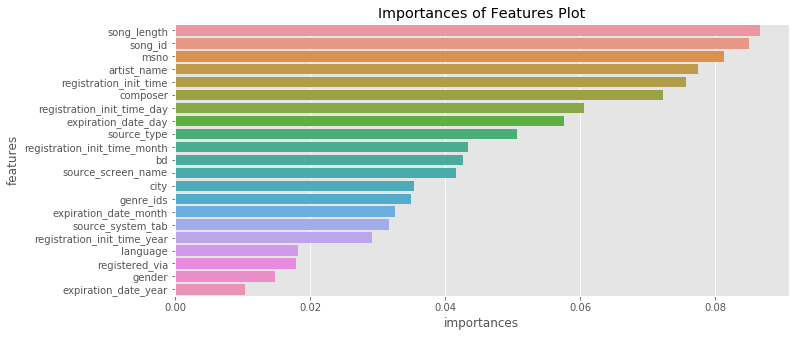

In [15]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [16]:
# Drop columns with importances < 0.04
df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [17]:
# Selected columns
df.columns

Index(['msno', 'song_id', 'source_screen_name', 'source_type', 'target',
       'song_length', 'artist_name', 'composer', 'bd',
       'registration_init_time', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_day'],
      dtype='object')

In [18]:
# Train & Test split
target = df.pop('target')
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(df, target, test_size = 0.3)

# Delete df
del df

In [19]:
model = xgb.XGBClassifier()

In [20]:
parameters_grid = { 'learning_rate' : [0.1, 0.2, 0.5], 'max_depth' : [5, 10, 15], 'n_estimators' : [150, 250, 300], 'min_child_weight' : [3, 5, 10] }

In [21]:
cv = cross_validation.StratifiedShuffleSplit(train_labels, n_iter = 3, test_size = 0.3)

In [22]:
grid_cv = grid_search.RandomizedSearchCV(model, parameters_grid, scoring = 'accuracy', cv = cv)

In [23]:
grid_cv.fit(train_data, train_labels)

KeyboardInterrupt: 

In [ ]:
grid_cv.bestestimator



In [24]:
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=15, min_child_weight=5, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [25]:
# Predicting
predict_labels = model.predict(test_data)

In [26]:
print(metrics.classification_report(test_labels, predict_labels))

             precision    recall  f1-score   support

          0       0.63      0.60      0.61     11048
          1       0.62      0.65      0.63     11085

avg / total       0.62      0.62      0.62     22133

